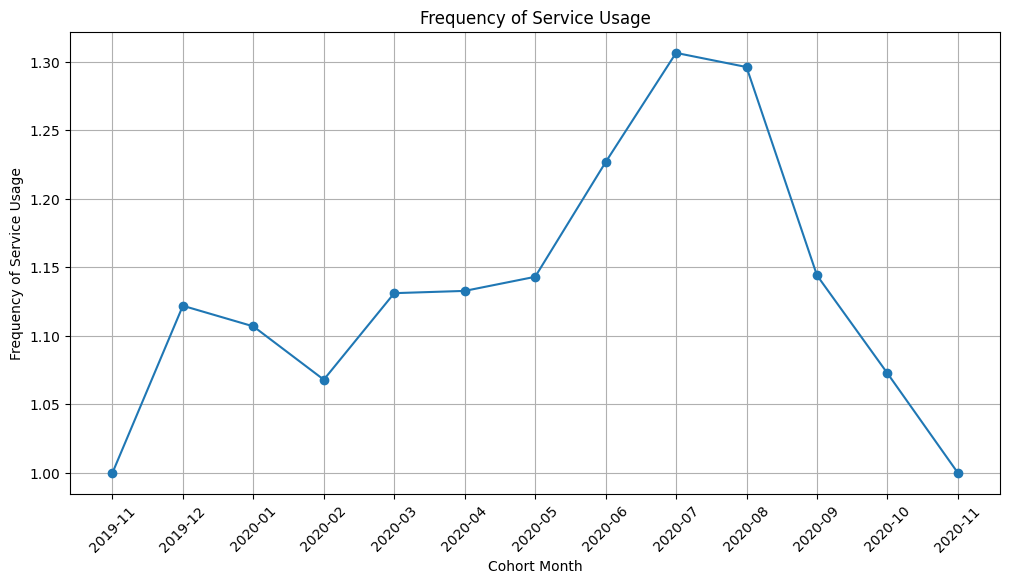

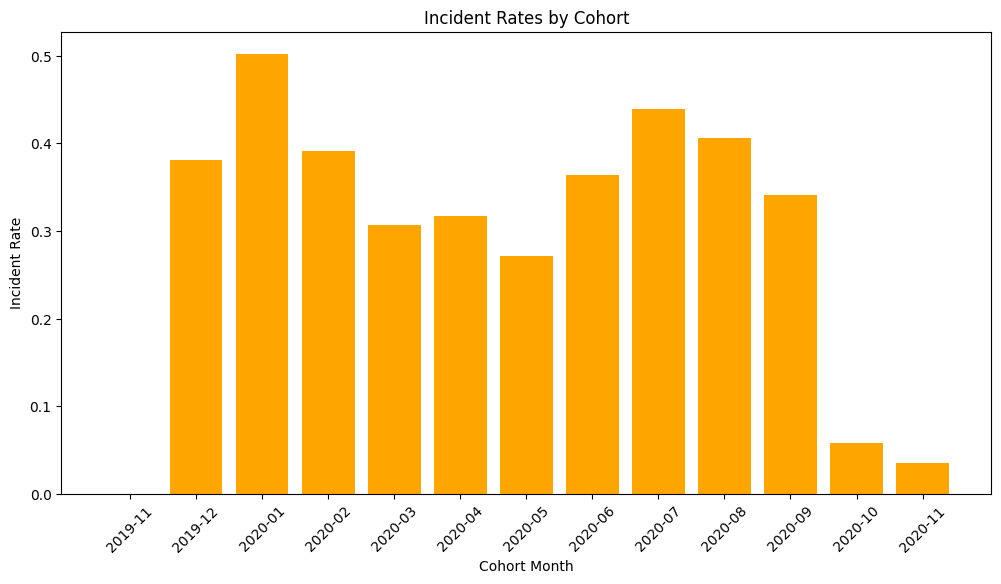

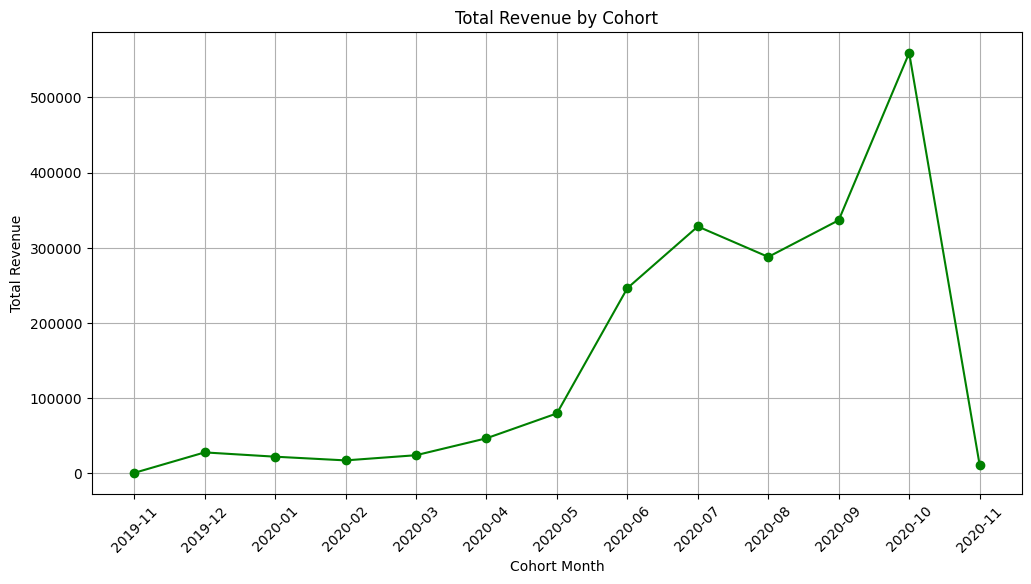

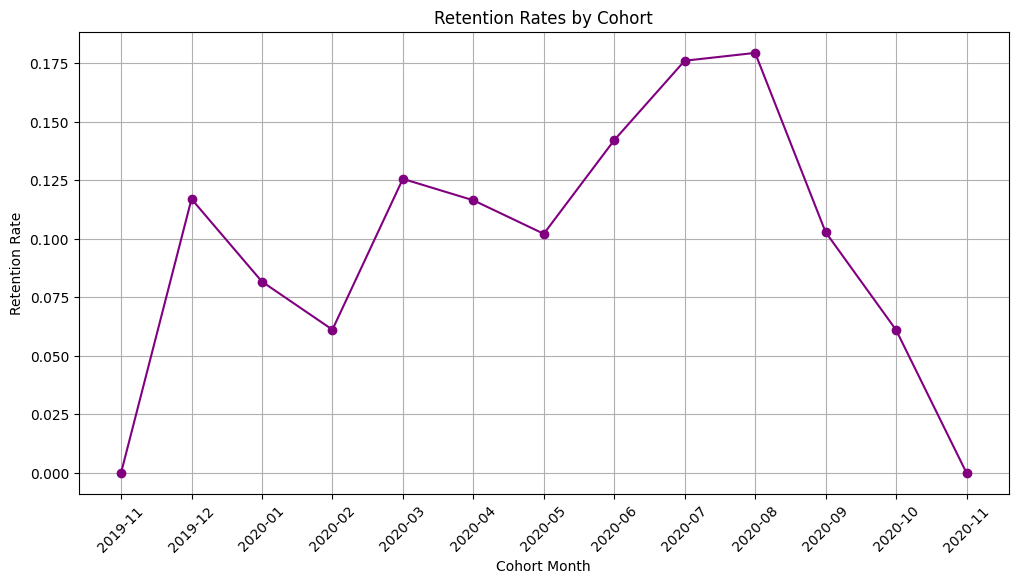

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload the dataset from the CSV file
file_path = 'merged_data.csv'
data = pd.read_csv(file_path)

# Cleaning and preparing the data
# Drop rows where 'amount' is missing and create a copy of the resulting DataFrame
data_cleaned = data.dropna(subset=['amount']).copy()

# Fill missing 'status_cash_request' with 'unknown'
# This ensures that there are no missing values in the 'status_cash_request' column
data_cleaned['status_cash_request'] = data_cleaned['status_cash_request'].fillna('unknown')

# Convert 'created_at_cash_request' to datetime format and remove timezone information
# This allows us to manipulate and extract date-related information from this column
data_cleaned['created_at_cash_request'] = pd.to_datetime(data_cleaned['created_at_cash_request'], errors='coerce').dt.tz_localize(None)

# Extract cohort month and year
# Create a new column 'cohort_month' that contains the year and month when the first cash advance was made
data_cleaned['cohort_month'] = data_cleaned['created_at_cash_request'].dt.to_period('M')

# Calculate the average usage per user in each cohort
# Group by 'cohort_month' and 'user_id' to count the number of transactions for each user
cohort_usage = data_cleaned.groupby(['cohort_month', 'user_id']).size().reset_index(name='usage_count')
# Calculate the mean usage count for each cohort month to get the average usage per user
cohort_frequency = cohort_usage.groupby('cohort_month')['usage_count'].mean().reset_index()
cohort_frequency.columns = ['cohort_month', 'Frequency of Service Usage']

# Calculate incident rates for each cohort
# Create a new column 'incident' where 1 indicates a 'rejected' status and 0 otherwise
data_cleaned['incident'] = data_cleaned['status_cash_request'].apply(lambda x: 1 if x == 'rejected' else 0)
# Calculate the mean of incidents for each cohort month to get the incident rate
cohort_incident_rate = data_cleaned.groupby('cohort_month')['incident'].mean().reset_index()
cohort_incident_rate.columns = ['cohort_month', 'incident_rate']

# Calculate total revenue generated by each cohort
# Sum the 'amount' for each 'cohort_month' to get the total revenue
cohort_revenue = data_cleaned.groupby('cohort_month')['amount'].sum().reset_index()
cohort_revenue.columns = ['cohort_month', 'total_revenue']

# Calculate retention rates for each cohort
# Determine the percentage of users in each cohort who made more than one transaction
cohort_retention = cohort_usage.groupby('cohort_month')['usage_count'].apply(lambda x: (x > 1).mean()).reset_index()
cohort_retention.columns = ['cohort_month', 'retention_rate']

# Combine all metrics into one DataFrame
combined_cohort_data = cohort_frequency.merge(cohort_incident_rate, on='cohort_month')
combined_cohort_data = combined_cohort_data.merge(cohort_revenue, on='cohort_month')
combined_cohort_data = combined_cohort_data.merge(cohort_retention, on='cohort_month')

# Save the combined cohort data to a single CSV file
combined_cohort_data.to_csv('cohort_analysis_data.csv', index=False)

# Visualize the metrics

# Plotting the Frequency of Service Usage
plt.figure(figsize=(12, 6))
plt.plot(cohort_frequency['cohort_month'].astype(str), cohort_frequency['Frequency of Service Usage'], marker='o')
plt.title('Frequency of Service Usage')
plt.xlabel('Cohort Month')
plt.ylabel('Frequency of Service Usage')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting the Incident Rates by Cohort
plt.figure(figsize=(12, 6))
plt.bar(combined_cohort_data['cohort_month'].astype(str), combined_cohort_data['incident_rate'], color='orange')
plt.title('Incident Rates by Cohort')
plt.xlabel('Cohort Month')
plt.ylabel('Incident Rate')
plt.xticks(rotation=45)
plt.show()

# Plotting the Total Revenue by Cohort
plt.figure(figsize=(12, 6))
plt.plot(combined_cohort_data['cohort_month'].astype(str), combined_cohort_data['total_revenue'], marker='o', color='green')
plt.title('Total Revenue by Cohort')
plt.xlabel('Cohort Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plotting the Retention Rates by Cohort
plt.figure(figsize=(12, 6))
plt.plot(combined_cohort_data['cohort_month'].astype(str), combined_cohort_data['retention_rate'], marker='o', color='purple')
plt.title('Retention Rates by Cohort')
plt.xlabel('Cohort Month')
plt.ylabel('Retention Rate')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
